# **PRÁCTICA: Clasificación con vecinos más cercanos**

En esta práctica decidimos utilizar el dataset "Breast Cancer Wisconsin" debido a su buen acoplamiento a modelos de clasificación como k-nn, nos permite hacer la clasificación de 2 clases (diagnostico de tumor benigno o maligno) a partir de 30 variables de medición como por ejemplo; el valor medio de el área, radio, textura, perímetro y suavidad del tumor.

El diagnóstico oportuno de el cancer de mama es un factor importante entre la vida y la muerte de la/el paciente.

In [ ]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, f1_score, log_loss, roc_auc_score,
                             confusion_matrix, ConfusionMatrixDisplay,
                             RocCurveDisplay, classification_report)
from sklearn.decomposition import PCA


In [ ]:
# Carga de datos
url= "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
df= pd.read_csv(url, header=None)

# *Análisis exploratorio inicial y limpieza de datos*

In [ ]:
# Nombramos las columnas ya que originalmente no tienen nombre
column_names= ["ID", "Diagnosis", "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
               "compactness_mean", "concavity_mean", "concave_points_mean", "symmetry_mean", "fractal_dimension_mean",
               "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se", "compactness_se", "concavity_se",
               "concave_points_se", "symmetry_se", "fractal_dimension_se", "radius_worst", "texture_worst", "perimeter_worst",
               "area_worst", "smoothness_worst", "compactness_worst", "concavity_worst", "concave_points_worst",
               "symmetry_worst", "fractal_dimension_worst"]
df.columns= column_names
df.columns

Index(['ID', 'Diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [ ]:
df.head()

,ID,Diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
print("(Filas, columnas) =",df.shape)

(Filas, columnas) = (569, 32)


In [ ]:
print("Tipos de datos:", df.dtypes.value_counts())

Tipos de datos: float64    30
int64       1
object      1
Name: count, dtype: int64


In [ ]:
print("Valores nulos:", df.isnull().sum().sum())
print("Valores duplicados:", df.duplicated().sum())

Valores nulos: 0
Valores duplicados: 0


In [ ]:
desc= df.describe()
print("Descripción estadística:\n", desc.T.head())

Descripción estadística:
                 count          mean           std       min        25%  \
ID              569.0  3.037183e+07  1.250206e+08  8670.000  869218.00   
radius_mean     569.0  1.412729e+01  3.524049e+00     6.981      11.70   
texture_mean    569.0  1.928965e+01  4.301036e+00     9.710      16.17   
perimeter_mean  569.0  9.196903e+01  2.429898e+01    43.790      75.17   
area_mean       569.0  6.548891e+02  3.519141e+02   143.500     420.30   

                      50%         75%           max  
ID              906024.00  8813129.00  9.113205e+08  
radius_mean         13.37       15.78  2.811000e+01  
texture_mean        18.84       21.80  3.928000e+01  
perimeter_mean      86.24      104.10  1.885000e+02  
area_mean          551.10      782.70  2.501000e+03  


Distribución de clases:

 Diagnosis
B    357
M    212
Name: count, dtype: int64


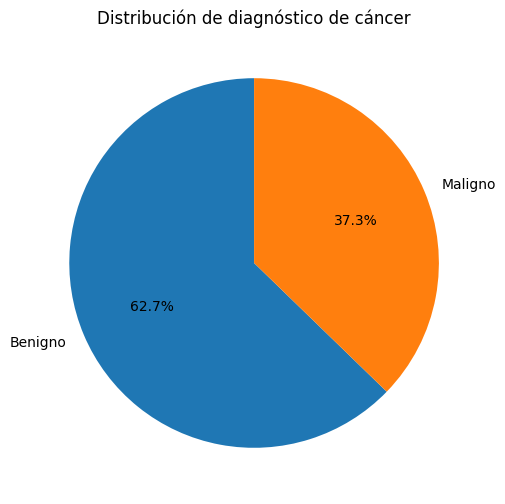

In [ ]:
print("Distribución de clases:\n\n", df["Diagnosis"].value_counts())
plt.figure(figsize=(8, 6))
plt.pie(df["Diagnosis"].value_counts(), labels=["Benigno", "Maligno"], autopct= "%1.1f%%", startangle= 90)
plt.title("Distribución de diagnóstico de cáncer")
plt.show()

# *KNN y métricas*

In [ ]:
X= df.loc[:, column_names[2:]].apply(pd.to_numeric, errors= 'coerce')
y= df['Diagnosis'].map({'B': 0, 'M': 1}).astype(int) #Convertimos Diagnosis a numérico

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.25, random_state= 42, stratify= y)

In [ ]:
pipe= Pipeline([('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier())])

In [ ]:
# Búsqueda de hiperpárametros
param_grid= {
    'knn__n_neighbors': [1,3,5,7,9,11,15,21,31],
    'knn__weights': ['uniform', 'distance'],    # Estándar VS Ponderado
    'knn__metric': ['minkowski', 'chebyshev'],  # Distancias variadas
    'knn__p': [1,2,3]                           # p aplica sólo a Minkowski
}

cv= StratifiedKFold(n_splits= 5, shuffle= True, random_state= 42)
grid= GridSearchCV(pipe, param_grid, cv= cv, scoring= 'accuracy', n_jobs= -1, refit= True)
grid.fit(X_train, y_train)

print("Mejor configuración (CV):", grid.best_params_)
print("Mejor accuracy (CV):", grid.best_score_)

Mejor configuración (CV): {'knn__metric': 'minkowski', 'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'uniform'}
Mejor accuracy (CV): 0.9718194254445965


In [ ]:
# Evaluación en test (incluye probabilístico)
best= grid.best_estimator_
y_pred= best.predict(X_test)
y_proba= best.predict_proba(X_test)[:,1]

acc= accuracy_score(y_test, y_pred)
f1_b= f1_score(y_test, y_pred, average= 'binary')
f1_m= f1_score(y_test, y_pred, average= 'macro')
ll= log_loss(y_test, best.predict_proba(X_test))
auc= roc_auc_score(y_test, y_proba)

print(f"Test accuracy: {acc:.4f}")
print(f"Test F1 (binario): {f1_b:.4f} | F1 (macro): {f1_m:.4f}")
print(f"Test Log Loss: {ll:.4f}")
print(f"Test ROC-AUC: {auc:.4f}")
print("\nReporte de clasificación:\n\n", classification_report(y_test, y_pred, target_names= ["Maligno", "Benigno"]))

Test accuracy: 0.9720
Test F1 (binario): 0.9608 | F1 (macro): 0.9695
Test Log Loss: 0.5450
Test ROC-AUC: 0.9790

Reporte de clasificación:

               precision    recall  f1-score   support

     Maligno       0.96      1.00      0.98        90
     Benigno       1.00      0.92      0.96        53

    accuracy                           0.97       143
   macro avg       0.98      0.96      0.97       143
weighted avg       0.97      0.97      0.97       143



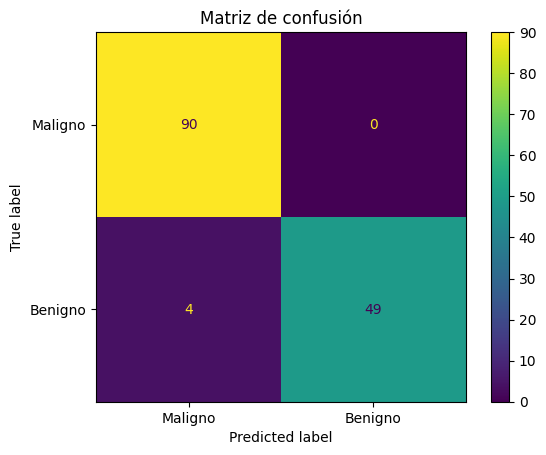

In [ ]:
# Matriz de confusión
matrix= confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(matrix, display_labels= ["Maligno", "Benigno"]).plot(values_format="d")
plt.title("Matriz de confusión")
plt.show()

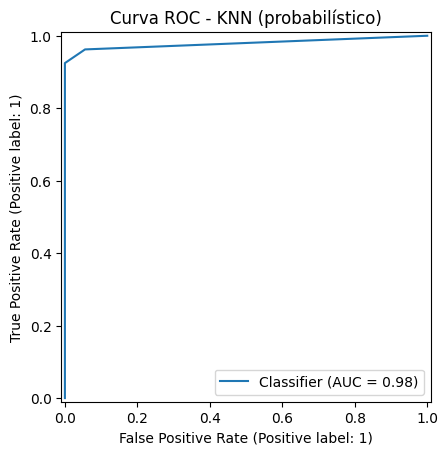

In [ ]:
# Curva ROC
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Curva ROC - KNN (probabilístico)")
plt.show()

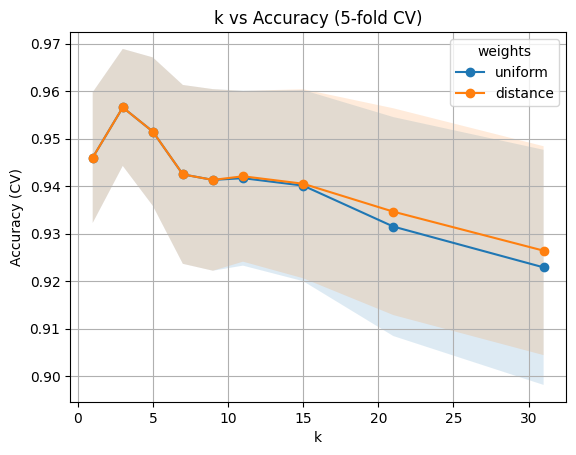

In [ ]:
# Curva k vs accuracy, comparando uniform vs distance
cvres= pd.DataFrame(grid.cv_results_)
cv_min= cvres[['param_knn__n_neighbors', 'param_knn__weights', 'mean_test_score', 'std_test_score']].copy()
cv_min.rename(columns= {'param_knn__n_neighbors': 'k',
                        'param_knn__weights': 'weights',
                        'mean_test_score': 'mean_acc',
                        'std_test_score': 'std_acc'}, inplace= True)
agg= (cv_min.groupby(['k', 'weights'])
              .agg(mean_acc= ('mean_acc', 'mean'), std_acc= ('std_acc', 'mean'))
              .reset_index())
plt.figure()
for w in ['uniform', 'distance']:
    sub= agg[agg['weights']== w].sort_values('k')
    plt.plot(sub['k'], sub['mean_acc'], marker= 'o', label= w)
    lo, hi= sub['mean_acc']-sub['std_acc'], sub['mean_acc']+sub['std_acc']
    plt.fill_between(sub['k'], lo, hi, alpha= 0.15)
plt.xlabel('k')
plt.ylabel('Accuracy (CV)')
plt.title('k vs Accuracy (5-fold CV)')
plt.legend(title= 'weights')
plt.grid(True)
plt.show()

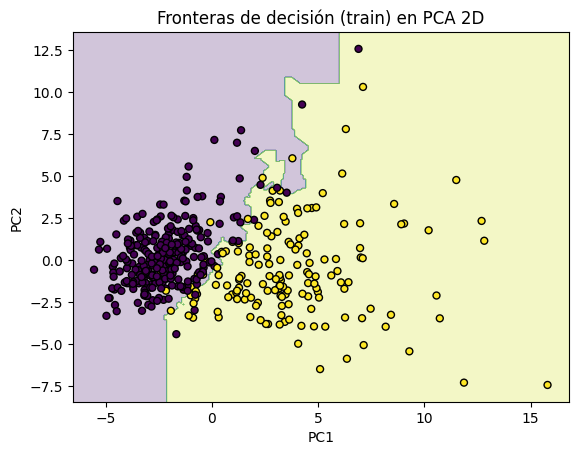

In [ ]:
# Visualización de fronteras
pca= PCA(n_components= 2)
X_train_s= best.named_steps['scaler'].transform(X_train)
X_test_s= best.named_steps['scaler'].transform(X_test)
Xtr_2d= pca.fit_transform(X_train_s)
Xte_2d= pca.transform(X_test_s)

# Entrenamos un kNN equivalente en el espacio 2D para dibujar fronteras
knn2d= KNeighborsClassifier(
    n_neighbors= best.named_steps['knn'].n_neighbors,
    weights= best.named_steps['knn'].weights,
    metric= best.named_steps['knn'].metric,
    p= getattr(best.named_steps['knn'], 'p', 2)
)
knn2d.fit(Xtr_2d, y_train)

# Malla de decisión
x_min, x_max= Xtr_2d[:,0].min()-1, Xtr_2d[:,0].max()+1
y_min, y_max= Xtr_2d[:,1].min()-1, Xtr_2d[:,1].max()+1
xx, yy= np.meshgrid(np.linspace(x_min, x_max, 400),
                    np.linspace(y_min, y_max, 400))
Z= knn2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, alpha= 0.25)
plt.scatter(Xtr_2d[:,0], Xtr_2d[:,1], c= y_train, edgecolor= 'k', s= 25)
plt.title("Fronteras de decisión (train) en PCA 2D")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

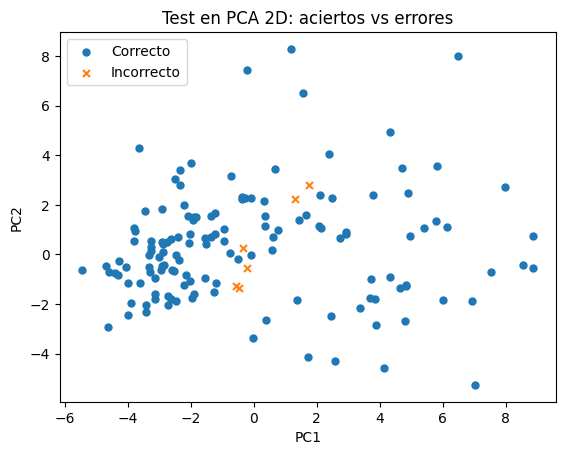

In [ ]:
# Aciertos/erores
y_pred_test2d= knn2d.predict(Xte_2d)
correcto= (y_pred_test2d == y_test)
plt.figure()
plt.scatter(Xte_2d[correcto,0], Xte_2d[correcto,1], marker= 'o', label= 'Correcto', s= 25)
plt.scatter(Xte_2d[~correcto,0], Xte_2d[~correcto,1], marker= 'x', label= 'Incorrecto', s= 25)
plt.legend()
plt.title("Test en PCA 2D: aciertos vs errores")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()